In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
# Define the color map
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

## arrange data
female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

In [6]:
# avarage per age or session
m_df= male_df.groupby(['age','uuid']).mean()
avg_m_df = male_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
avg_f_df = female_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

#m_data= m_data.groupby('age').mean()
f_data= f_df.groupby(['age','uuid']).mean()
m_data= m_df.groupby(['age','uuid']).mean()

# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

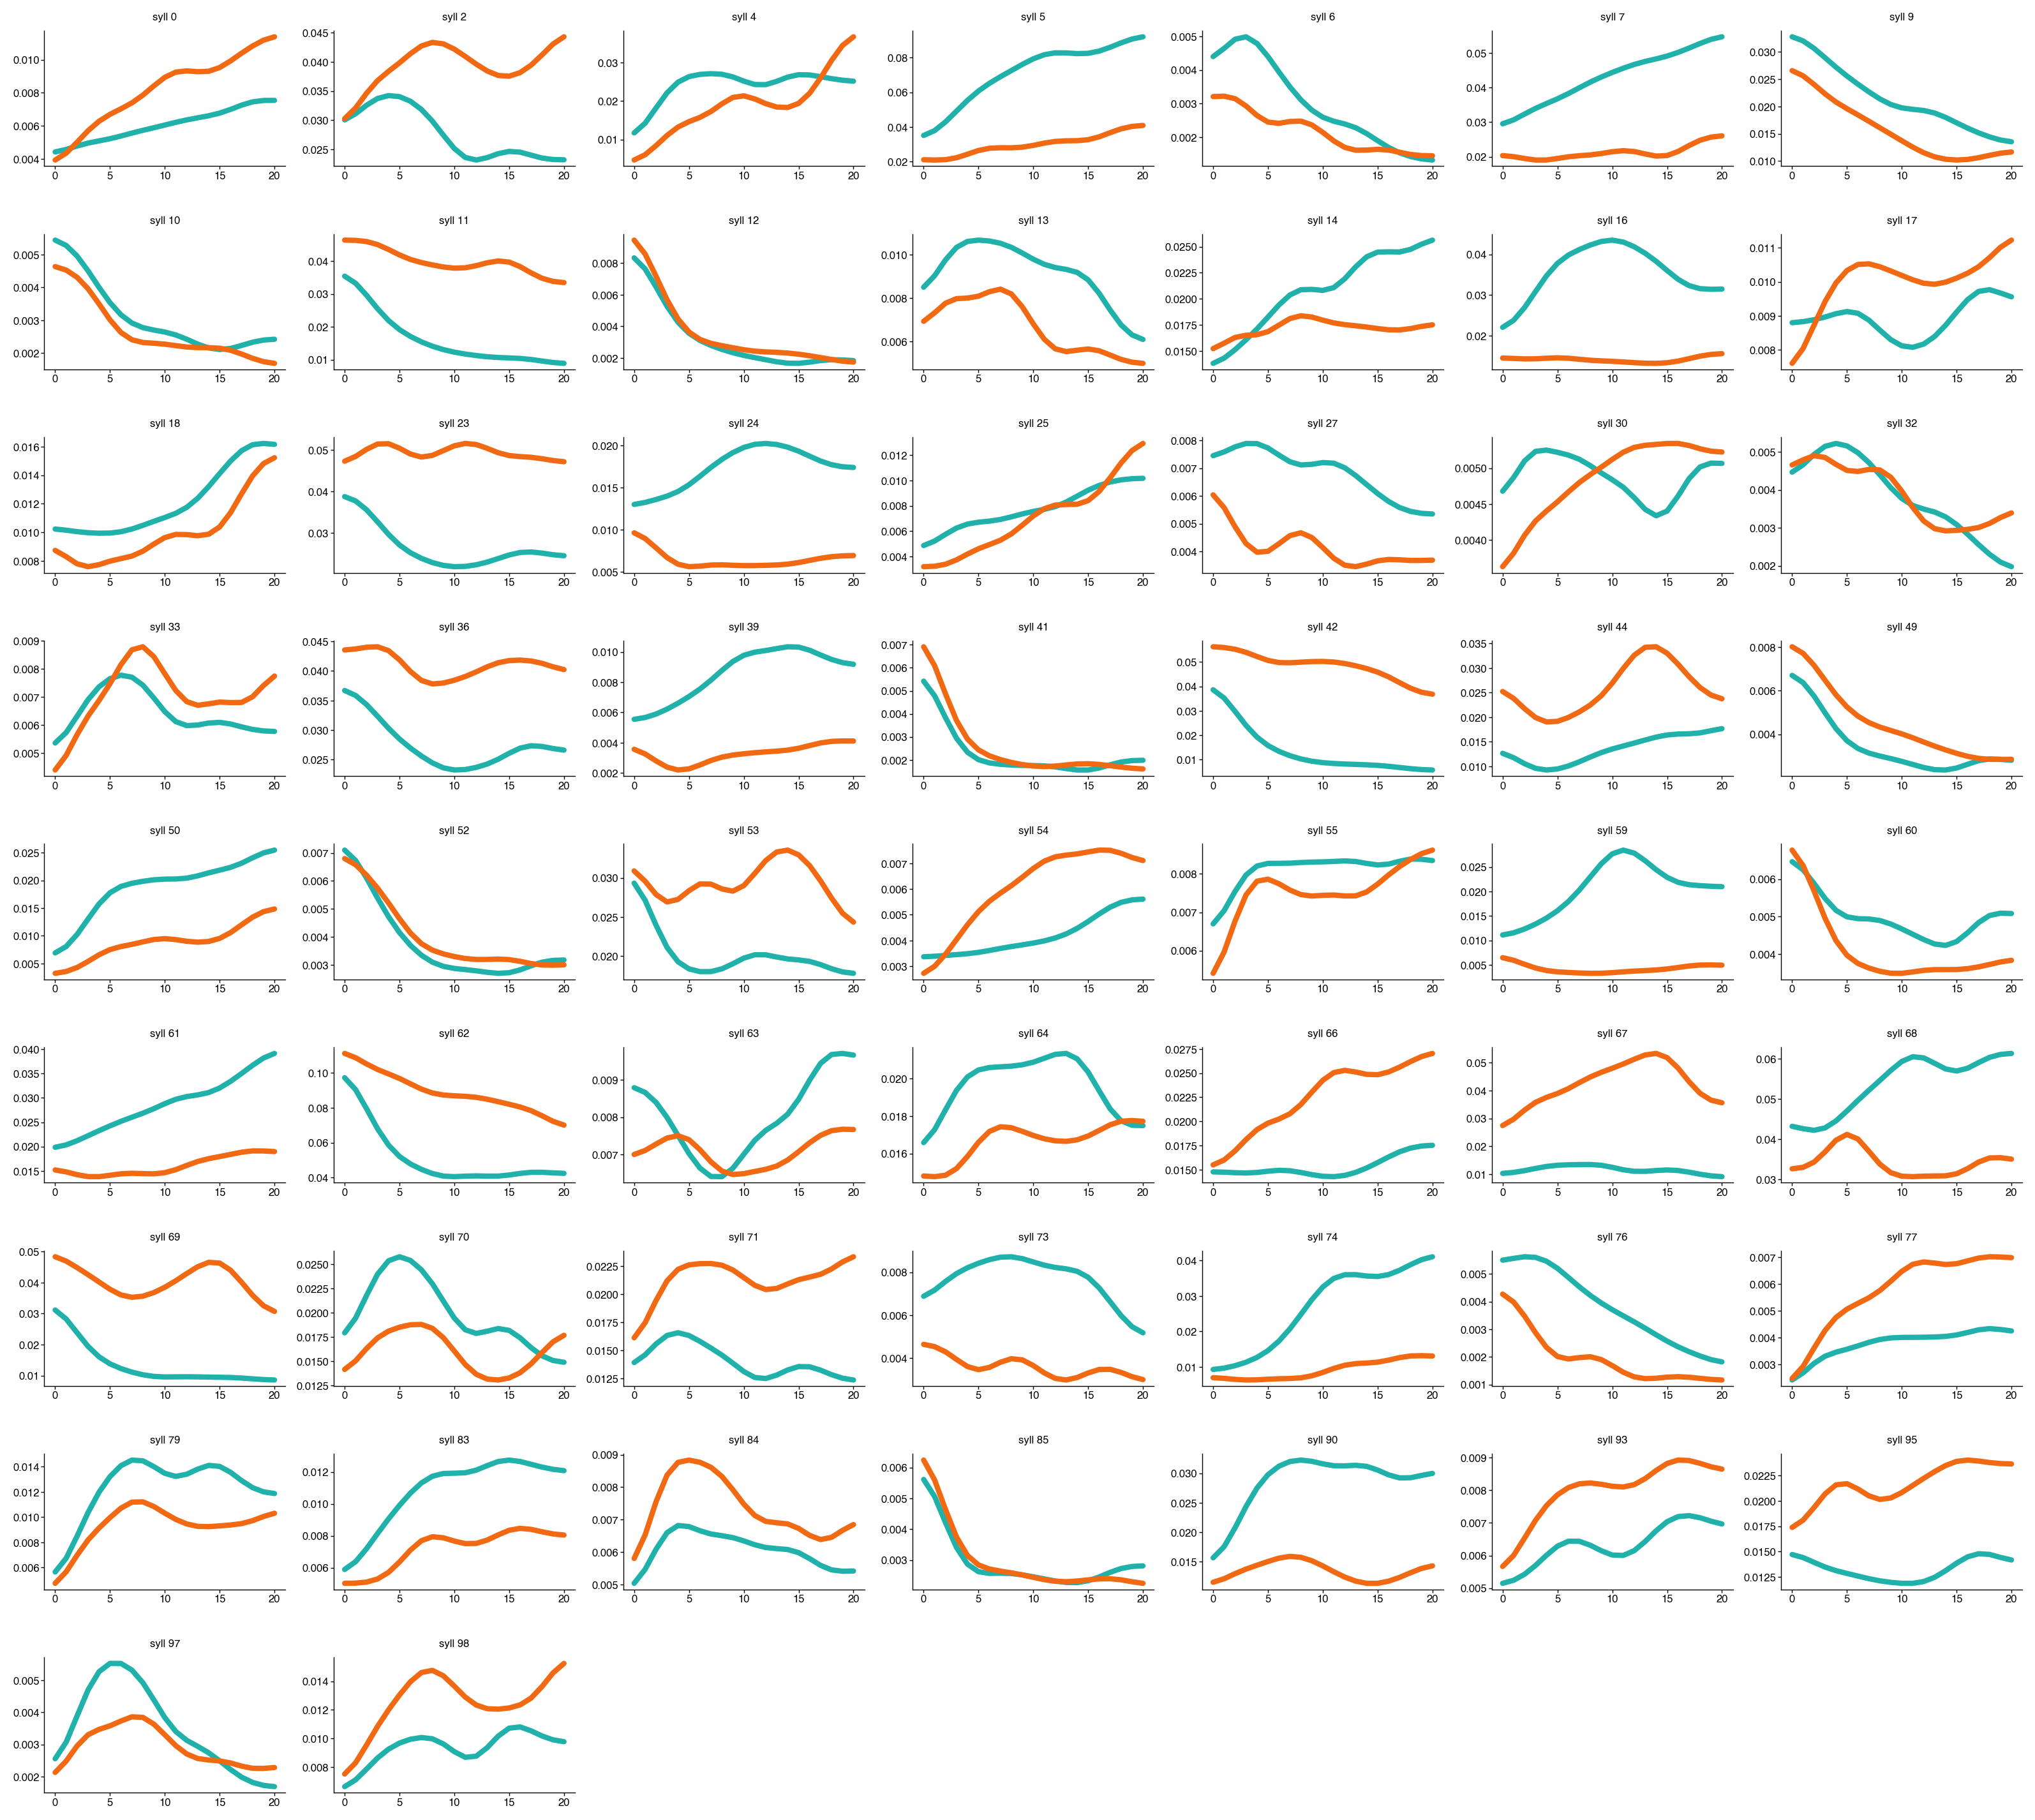

In [10]:
from scipy.ndimage import gaussian_filter1d

# plot some example syllbles:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
n=0
syll=keep_syllables
for s in syll:
    m = m_data.groupby('age').mean()[s].values
    f= f_data.groupby('age').mean()[s].values
    ax = plt.subplot(10, 7, n + 1)
    #plt.plot(m, color='purple', lw=3)
    #plt.plot(f, color='#d94801',lw=3)
    plt.plot(gaussian_filter1d(m,2), color='#20B2AA', lw=3)
    plt.plot(gaussian_filter1d(f,2), color='#f16913',lw=3)
    ax.set_title('syll ' + str(s))
    #ax.set_ylim([0, 0.08])
    sns.despine()
    n=n+1
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_example.pdf')